#  Modeling Coffee Reviews with Linear Model
## Will Rodman | Final Project | MATH-6040 Linear Models

This project studies data from [coffeereview.com](https://www.coffeereview.com), which was obtained through web scraping and published on [kaggle.com](https://www.kaggle.com). The goal is to develop a linear regression model that predicts individual ratings for coffee beans. Additonal quesitons answered about the data include: 
- What features of a coffee bean best determine a rating? 
- How do ratings compare to the level of coffee beans roast? 
- How well can a linear model be fit to predict coffee bean ratings? 

**Project Sections:**
1. Loading and cleaning the dataset. 
2. Visualizing numerical features. 
3. Visualizing categorical features. 
4. Transforming and testing numerical features.
5. Fitting Linear Regression

**Data source:** [Link](https://www.kaggle.com/datasets/hanifalirsyad/coffee-scrap-coffeereview/versions/2/data?select=coffee_df.csv)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Sprint 1: Loading and cleaning the dataset. 

The CSV files [coffee_df](./data/coffee_df.csv) and [coffee_analysis](./data/coffee_analysis.csv) are two different versions of the data that has been scraped. In order to use features from both datasets, I merge the two datasets and drop the duplicate values.

In [2]:
coffee_columns = ['acid', 'body', 'flavor', 'aftertaste', 'desc_1']
analysis_columns = ['loc_country', 'roast', '100g_USD', 'rating', 'desc_1']

coffee_df = pd.read_csv('data/coffee_df.csv', usecols=coffee_columns)
analysis_df = pd.read_csv('data/coffee_analysis.csv', usecols=analysis_columns)

df = pd.merge(coffee_df, analysis_df, on='desc_1', how='inner')


df.drop(['desc_1'], axis=1, inplace=True)
df.dropna(inplace=True)
df['roast'] = df['roast'].str.replace('-', '_')

dtypes = {
    'acid': int,
    'body': int,
    'flavor': int,
    'aftertaste': int,
    'roast': 'category',
    'loc_country': 'category',
    '100g_USD': float,
    'rating': int,
}

df = df.astype(dtypes)

In [3]:
print("Dimensions", df.shape)
print('Data Types: \n', df.dtypes)
df.head(10)

Dimensions (1779, 8)
Data Types: 
 acid              int64
body              int64
flavor            int64
aftertaste        int64
roast          category
loc_country    category
100g_USD        float64
rating            int64
dtype: object


,acid,body,flavor,aftertaste,roast,loc_country,100g_USD,rating
0,9,9,9,8,Medium_Light,United States,12.93,94
1,9,9,9,8,Medium_Light,United States,6.17,93
2,9,8,9,8,Medium_Light,United States,5.58,92
3,8,8,9,8,Medium_Light,United States,9.17,92
4,8,9,9,8,Medium_Light,Taiwan,8.80,92
5,8,8,9,8,Light,Taiwan,6.08,92
6,9,8,9,7,Medium_Light,United States,5.88,91
7,9,8,9,7,Medium_Light,United States,5.88,91
8,9,9,9,9,Light,United States,13.23,95
9,9,9,9,8,Light,United States,8.11,94


Each row in the dataset represents an individual users rating for a coffee bean; here is a description for each feature:

- **acid**: Acidity levels ranging from 1 - 10.
- **body**: Body characteristic ranging from 1 - 10.
- **flavor**: Strength of flavor ranging from 1 - 10.
- **aftertaste**: Aftertaste persistence ranging from 1 - 10.
- **roast**: Level of roast. 
- **loc_country**: Location of a users rating.
- **100g_USD**: Price per 100 grams in USD.
- **rating**: Overall rating ranging from 1 - 100.

Since the `roast` feature is an ordinal data type, this feature needs to be sorted.Ordered table for the roast feature:
| Roast         | Level |
|---------------|-------|
| Light         | 1     |
| Medium-Light  | 2     |
| Medium        | 3     |
| Medium-Dark   | 4     |
| Dark          | 5     |


In [4]:
roast_types = ['Light', 'Medium_Light', 'Medium', 'Medium_Dark', 'Dark']
df['roast'] = pd.Categorical(df['roast'], categories=roast_types, ordered=True)

### Sprint 2: Visualizing numeric features. 

Now that the dataset is clean, all the features in the dataset can be analyzed. This analysis will determine which features can be used in the linear regression model. Specifically, I will compute the Pearson correlation, print a summary of statistics, as well as plot the feature distributions and create box plot comparisons

I will first start by printing some statistics about the distributions of numerical features.

In [5]:
description = df.describe().loc[['mean', 'std', 'min', 'max']]
skewness = df.skew().rename('skew')
description = description.append(skewness)
description

/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_34219/1274467858.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = df.skew().rename('skew')
/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_34219/1274467858.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  description = description.append(skewness)


,acid,body,flavor,aftertaste,100g_USD,rating
mean,8.516020,8.637437,8.981450,8.110736,9.522327,93.100056
std,0.547154,0.496980,0.327230,0.479727,10.935001,1.578859
min,6.000000,7.000000,7.000000,6.000000,0.170000,84.000000
max,10.000000,10.000000,10.000000,9.000000,132.280000,98.000000
skew,-0.475956,-0.736499,-0.745512,0.237914,5.416931,-0.947961


Next, I will plot the distributions of these same features using a histogram.

In [6]:
ordinal_features = ['acid', 'body', 'flavor', 'aftertaste', '100g_USD', 'rating']
features_bins = [4, 4, 4, 5, 15, 15]

fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(8, 25))
fig.subplots_adjust(hspace=0.25)

for i, column in enumerate(ordinal_features):
    axs[i].hist(df[column], bins=features_bins[i], color='blue', alpha=0.7)

    axs[i].set_title(f'Distribution of {column}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(column)

plt.savefig("images/hist.svg")

Looking at the 6 histogram plots: the feature **100g_USD appears to be exponentially distributed**, while the other 5 distributions appear to center around the mean. The rating feature appears to be the closest to a normal distribution.

Next, I will visualize the numerical features using a box plot comparison, where the distributions for 5 numerical features are plotted against the range of rating feature values.

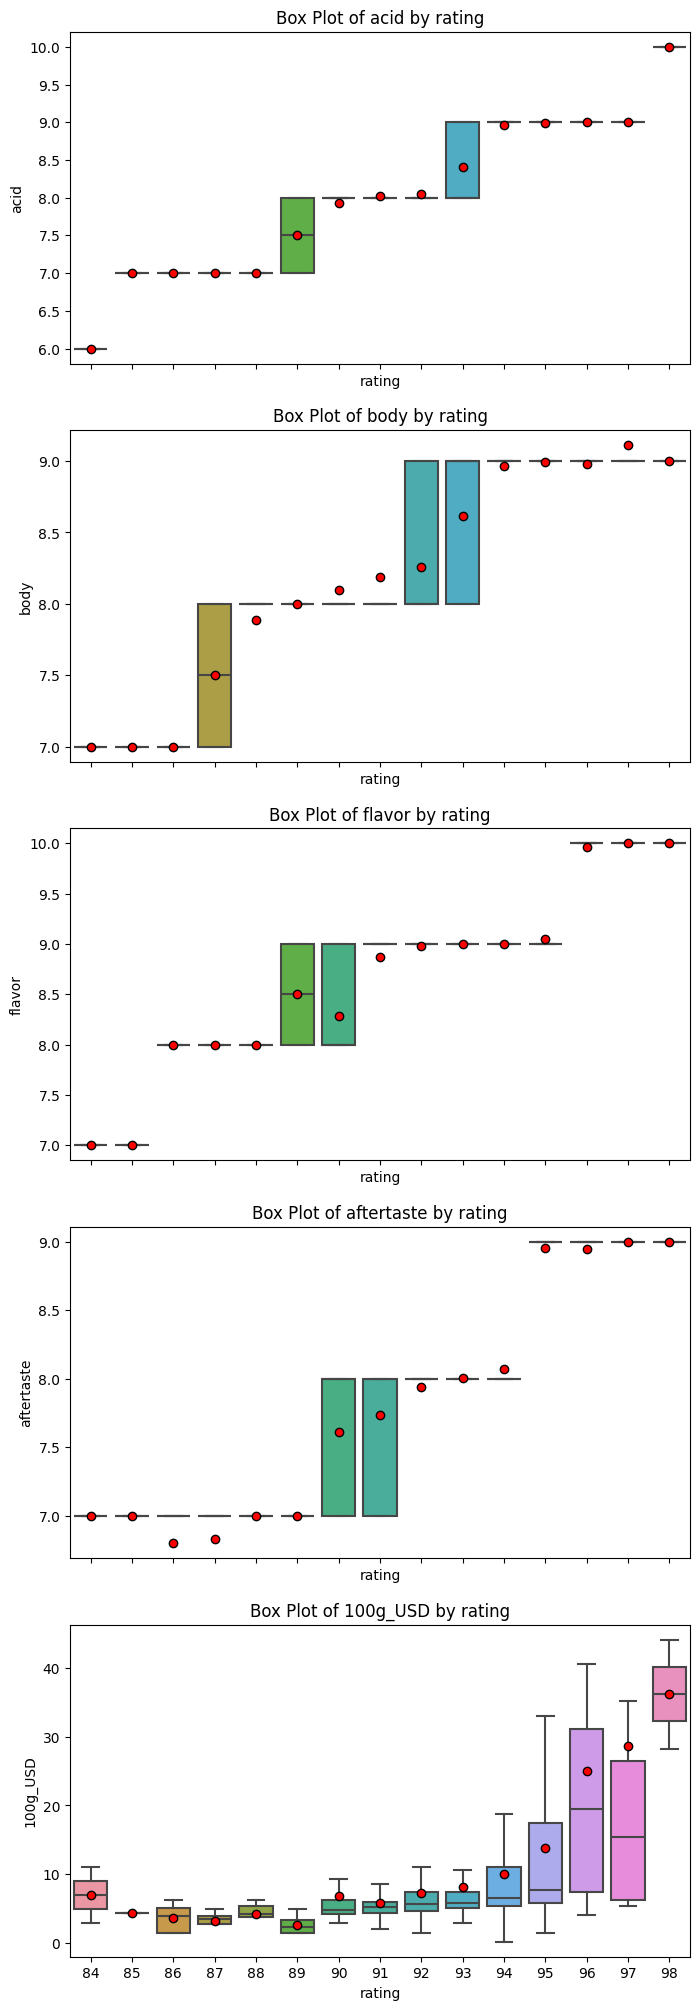

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 25), sharex=True)

for ax, feature in zip(axes, ordinal_features[:-1]):
    sns.boxplot(x='rating', y=feature, data=df, ax=ax, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black"}, showfliers=False)
    ax.set_title(f'Box Plot of {feature} by rating')
    ax.set_xlabel('rating')
    ax.set_ylabel(feature)

plt.savefig("images/box_plot.svg")

Looking at the 5 box plot comparisons, the box plot of `100g_USD` and rating appear to have an exponential relationship, while the other 4 box plot comparisons appear to have a linear relationship. However, these 4 box plots have a J-shaped relationship that indicates the `body`, `flavor`, and `acid` distributions are negatively skewed and the `aftertaste` distribution is positively skewed.

In [ ]:
corr_matrix = df[ordinal_features].corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,acid,body,flavor,aftertaste,100g_USD,rating
acid,1.000000,0.303699,0.373901,0.450708,0.178089,0.758571
body,0.303699,1.000000,0.304462,0.312396,0.174092,0.651938
flavor,0.373901,0.304462,1.000000,0.392868,0.234329,0.669822
aftertaste,0.450708,0.312396,0.392868,1.000000,0.250361,0.722725
100g_USD,0.178089,0.174092,0.234329,0.250361,1.000000,0.280223
rating,0.758571,0.651938,0.669822,0.722725,0.280223,1.000000


**Most and Least Correlated Features to Rating:** The `acid` has the highest correlation to `rating` with a coefficient of 75%. The feature `100g_USD` has the least correlation to `rating` with coefficient of 28%.

**High Correlations Among Other Features:** `Aftertaste` and `acid` have a relatively high correlation coefficient of 45%.

### Sprint 3: Visualizing the categorical features. 

For the categorical features, I will start by printing the number of observations per category.

In [ ]:
categorical_features = ['roast', 'loc_country']

for feature in categorical_features:
    values = df[feature].value_counts()
    print(f"Number of {feature} Cats:", len(values)) 
    print(values, '\n')

Number of roast Cats: 5
Medium_Light    1304
Light            280
Medium           175
Medium_Dark       16
Dark               4
Name: roast, dtype: int64 

Number of loc_country Cats: 17
United States              1210
Taiwan                      402
Hawai'i                      82
Guatemala                    27
Canada                       21
Hong Kong                    12
Japan                        11
Peru                          2
China                         2
England                       2
Mexico                        2
Uganda                        1
Australia                     1
New Taiwan                    1
Kenya                         1
Honduras                      1
United States And Floyd       1
Name: loc_country, dtype: int64 



Looking at the value counts, the Medium-Light category in `roast` and the United States category in `loc_country` both have more observations than all other categories in their respective features combined.

Next, I will visualize the categorical features using a box plot comparison, where the distributions for `rating` are plotted against each category for a feature. 

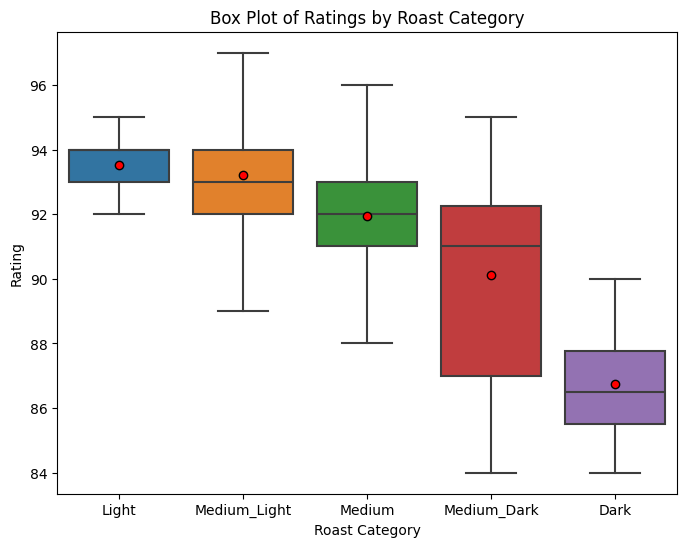

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='roast', y='rating', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black"}, showfliers=False)
plt.title('Box Plot of Ratings by Roast Category')
plt.xlabel('Roast Category')
plt.ylabel('Rating')

plt.savefig("images/box_plot_roast.svg")

Looking at the `rating` and `roast` box plot comparison, there appears to be a relationship where the mean `rating` decreases as the level of `roast` increases.

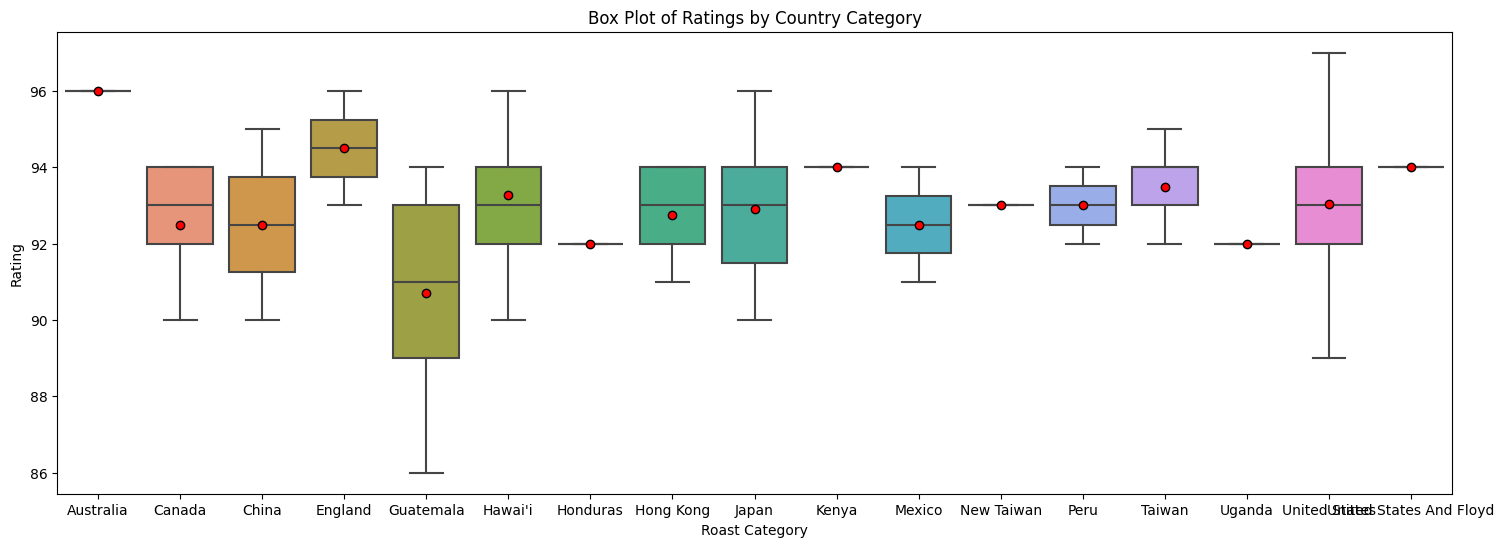

In [ ]:
plt.figure(figsize=(18, 6))
sns.boxplot(x='loc_country', y='rating', data=df, showmeans=True, meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"black"}, showfliers=False)
plt.title('Box Plot of Ratings by Country Category')
plt.xlabel('Roast Category')
plt.ylabel('Rating')

plt.savefig("images/box_plot_loc.svg")

Looking at the `rating` and `loc_country` box plot comparison, there does not appear to be significant variance in the means by `loc_country`.

### Sprint 4: Transforming and testing numerical features.

Looking at the plots of the distribution for the numerical features, they do not appear to be normally distributed. I will use the Shapiro-Wilk test for normality and use the Kolmogorov-Smirnov test for uniformity.

In [ ]:
print("Test for Normality:")
for column in ordinal_features:
    stat, p = stats.shapiro(df[column])
    print(f"    {column:12s}     stat: {stat:.3f}     p-value: {p:.3e}")

print("\n Test for Uniformity:") 
for column in ordinal_features:
    stat, p = stats.kstest(df[column], 'uniform')
    print(f"    {column:12s}     stat: {stat:.3f}     p-value: {p:.3e}")

Test for Normality:
    acid             stat: 0.699     p-value: 0.000e+00
    body             stat: 0.632     p-value: 0.000e+00
    flavor           stat: 0.427     p-value: 0.000e+00
    aftertaste       stat: 0.649     p-value: 0.000e+00
    100g_USD         stat: 0.485     p-value: 0.000e+00
    rating           stat: 0.920     p-value: 1.091e-29

 Test for Uniformity:
    acid             stat: 1.000     p-value: 0.000e+00
    body             stat: 1.000     p-value: 0.000e+00
    flavor           stat: 1.000     p-value: 0.000e+00
    aftertaste       stat: 1.000     p-value: 0.000e+00
    100g_USD         stat: 0.999     p-value: 0.000e+00
    rating           stat: 1.000     p-value: 0.000e+00


Looking at the results of the Shapiro-Wilk test, none of the features come from a normal distribution except for `rating`. Since `100g_USD` appears to be exponentially distributed, I will transform this to normality in order to minimize the outlier values. This will create a better fit for our models in Sprint 5.

Lambda for 100g_USD: -0.308
stat: 0.891     p-value: 9.273e-34


<Axes: ylabel='Frequency'>

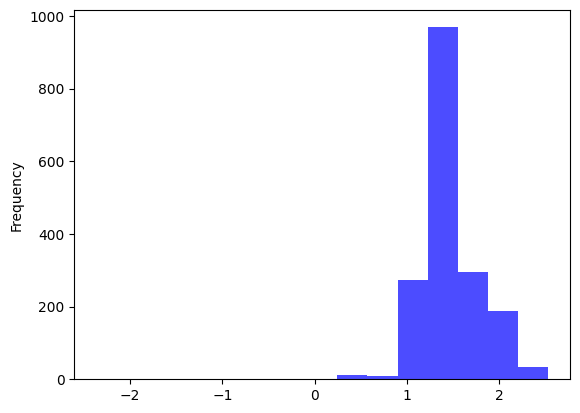

In [ ]:
df['100g_USD'], fitted_lambda = stats.boxcox(df['100g_USD'])
print("Lambda for 100g_USD:", round(fitted_lambda, 3))

stat, p = stats.shapiro(df['100g_USD'])
print(f"stat: {stat:.3f}     p-value: {p:.3e}")

df['100g_USD'].plot(kind='hist', bins=15, alpha=0.7, color='blue')

This feature is now more normally distributed.

### Sprint 5: Fitting Linear Regression

Here, I fit linear models using a variety of feature sets to find a model with the highest achieving F-statistic, R-squared and Log-Likelihood values.

First, I will fit a linear regression where `rating` is the **dependent variable** and all other nominal features are the **independent variables**; the fit is done using the least squares method. This linear equation is written as follows: 

$
\hat{rating} = \beta_0 + \beta_1 \text{acid} + \beta_2 \text{body} + \beta_3 \text{flavor} + \beta_4 \text{aftertaste} + \beta_5 \text{100g\_USD} + \epsilon \\
$

#### Model 1:

In [ ]:
X = df[['acid', 'body', 'flavor', 'aftertaste', '100g_USD']]
X = sm.add_constant(X)  
y = df['rating']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     7277.
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        14:03:58   Log-Likelihood:                -606.38
No. Observations:                1779   AIC:                             1225.
Df Residuals:                    1773   BIC:                             1258.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.8182      0.243    217.101      0.000      52.341      53.295
acid           1.1568      0.017     66.767      0.000       1.123       1.191
body           1.0814      0.018     60.724      0.000       1.047       1.116
flavor         1.3906      0.028     49.168      0.000       1.335       1.446
aftertaste     1.0522      0.020     52.384      0.000       1.013       1.092
100g_USD       0.0452      0.027      1.667      0.096      -0.008       0.098
==============================================================================
Omnibus:                      316.516   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              599.230
Skew:                          -1.078   Prob(JB):                    7.57e-131
Kurtosis:                       4.854   Cond. No.                         521.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After fitting this model, the **R-squared value is 95**%, and the **F-statistic is 7277**. The $P>|t| = 0.096$ for the `100g_USD` feature indicates that there is insufficient statistical significance to suggest that `100g_USD` has a meaningful impact on the model. Considering this, I will update the model to exclude the `100g_USD` feature.

#### Model 2:

In [ ]:
X = df[['acid', 'body', 'flavor', 'aftertaste']]
X = sm.add_constant(X)  
y = df['rating']

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     9086.
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        14:03:58   Log-Likelihood:                -607.78
No. Observations:                1779   AIC:                             1226.
Df Residuals:                    1774   BIC:                             1253.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.7393      0.239    220.886      0.000      52.271      53.208
acid           1.1597      0.017     67.233      0.000       1.126       1.194
body           1.0847      0.018     61.238      0.000       1.050       1.119
flavor         1.3963      0.028     49.709      0.000       1.341       1.451
aftertaste     1.0572      0.020     53.220      0.000       1.018       1.096
==============================================================================
Omnibus:                      319.244   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.524
Skew:                          -1.083   Prob(JB):                    7.25e-133
Kurtosis:                       4.876   Cond. No.                         509.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After fitting the updated model, the **R-squared value remains at 95%**, and the **F-statistic increases to 9086**. This means that the model now explains more of the variance in the data while explaining the `rating` feature just as well.

Now I will create a design matrix using the `roast` feature, to fit a model, which will be used for ANOVA. 

#### Model 3:

In [ ]:
design = pd.get_dummies(df[['roast', 'rating']], columns=['roast'])
design = sm.add_constant(design)
design.head(10)

,const,rating,roast_Light,roast_Medium_Light,roast_Medium,roast_Medium_Dark,roast_Dark
0,1.0,94,0,1,0,0,0
1,1.0,93,0,1,0,0,0
2,1.0,92,0,1,0,0,0
3,1.0,92,0,1,0,0,0
4,1.0,92,0,1,0,0,0
5,1.0,92,1,0,0,0,0
6,1.0,91,0,1,0,0,0
7,1.0,91,0,1,0,0,0
8,1.0,95,1,0,0,0,0
9,1.0,94,1,0,0,0,0


In [ ]:
model = ols('rating ~ roast_Light + roast_Medium_Light + roast_Medium', data=design).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     86.78
Date:                Sat, 04 May 2024   Prob (F-statistic):           2.13e-52
Time:                        14:03:58   Log-Likelihood:                -3214.5
No. Observations:                1779   AIC:                             6437.
Df Residuals:                    1775   BIC:                             6459.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             89.4500      0.330    271.085      0.000      88.803      90.097
roast_Light            4.0857      0.342     11.962      0.000       3.416       4.756
roast_Medium_Light     3.7663      0.332     11.327      0.000       3.114       4.418
roast_Medium           2.5043      0.348      7.190      0.000       1.821       3.187
==============================================================================
Omnibus:                      111.169   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.523
Skew:                          -0.439   Prob(JB):                     1.17e-46
Kurtosis:                       4.443   Cond. No.                         24.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the results, all roast categories significantly influence the rating, with **Light having the highest coefficient and t-statistic**.

I'll now combine the second and third models in an attempt to increase the R-squared value.

#### Model 4:

In [ ]:
X = pd.get_dummies(df[['acid', 'body', 'flavor', 'aftertaste', 'roast']], columns=['roast'], drop_first=False)
X.drop(['roast_Medium_Dark', 'roast_Dark'], axis=1, inplace=True)
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     5323.
Date:                Sat, 04 May 2024   Prob (F-statistic):               0.00
Time:                        14:03:58   Log-Likelihood:                -585.20
No. Observations:                1779   AIC:                             1186.
Df Residuals:                    1771   BIC:                             1230.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 52.7934      0.242    218.353      0.000      52.319      53.268
acid                   1.1372      0.017     65.332      0.000       1.103       1.171
body                   1.0760      0.018     61.270      0.000       1.042       1.110
flavor                 1.3857      0.028     49.811      0.000       1.331       1.440
aftertaste             1.0457      0.020     53.041      0.000       1.007       1.084
roast_Light            0.4303      0.081      5.327      0.000       0.272       0.589
roast_Medium_Light     0.4161      0.078      5.314      0.000       0.263       0.570
roast_Medium           0.2918      0.081      3.621      0.000       0.134       0.450
==============================================================================
Omnibus:                      322.890   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              631.879
Skew:                          -1.081   Prob(JB):                    6.16e-138
Kurtosis:                       4.961   Cond. No.                         524.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

While this updated model has the same **R-squared value of 95%** but a lower **F-statistic of 5323**, when comparing the log likelihood for all four models:

1. **Model 1:** -606.38
2. **Model 2:** -607.78
3. **Model 3:** -3214.0
4. **Model 4:** -585.20

This model has the highest log likelihood values, so it should be considered to have the best fit.

In [ ]:
!jupyter nbconvert --to html final.ipynb --output-dir=./output/ --output coffee_bean_linear_model

[NbConvertApp] Converting notebook final.ipynb to html
[NbConvertApp] Writing 994304 bytes to output/coffee_bean_linear_model.html


In [ ]:
!jupyter nbconvert --to latex final.ipynb --output-dir=./output/ --output coffee_bean_linear_model
!pdflatex final.tex

[NbConvertApp] Converting notebook final.ipynb to latex
/usr/local/lib/python3.9/site-packages/nbconvert/utils/pandoc.py:52: RuntimeWarning: You are using an unsupported version of pandoc (3.1.9).
Your version must be at least (1.12.1) but less than (3.0.0).
Refer to https://pandoc.org/installing.html.
Continuing with doubts...
  check_pandoc_version()
[NbConvertApp] Support files will be in coffee_bean_linear_model_files/
[NbConvertApp] Making directory ./output/coffee_bean_linear_model_files
[NbConvertApp] Making directory ./output/coffee_bean_linear_model_files
[NbConvertApp] Making directory ./output/coffee_bean_linear_model_files
[NbConvertApp] Making directory ./output/coffee_bean_linear_model_files
[NbConvertApp] Making directory ./output/coffee_bean_linear_model_files
[NbConvertApp] Writing 71113 bytes to output/coffee_bean_linear_model.tex
zsh:1: command not found: pdflatex
